Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 94/94 [36:08<00:00, 23.07s/it]



1. Overall Test Accuracy: 82.17%

Per-action Accuracy:
calling: 75.00%
clapping: 86.50%
cycling: 98.00%
dancing: 75.50%
drinking: 84.00%
eating: 86.00%
fighting: 77.50%
hugging: 89.00%
laughing: 82.00%
listening_to_music: 80.50%
running: 88.50%
sitting: 68.50%
sleeping: 80.00%
texting: 74.50%
using_laptop: 87.00%

2. Similarity Matrix (%):
Rows: True Action, Columns: Predicted Action Confidence

True calling:
  calling: 57.47%
  clapping: 3.04%
  cycling: 1.01%
  dancing: 0.77%
  drinking: 1.75%
  eating: 1.32%
  fighting: 0.75%
  hugging: 0.91%
  laughing: 1.58%
  listening_to_music: 8.62%
  running: 1.97%
  sitting: 3.15%
  sleeping: 1.55%
  texting: 11.38%
  using_laptop: 4.74%

True clapping:
  calling: 1.08%
  clapping: 72.99%
  cycling: 0.82%
  dancing: 0.77%
  drinking: 0.46%
  eating: 0.81%
  fighting: 1.09%
  hugging: 1.69%
  laughing: 6.33%
  listening_to_music: 1.24%
  running: 1.87%
  sitting: 4.39%
  sleeping: 0.84%
  texting: 3.14%
  using_laptop: 2.46%

True cycling:
  

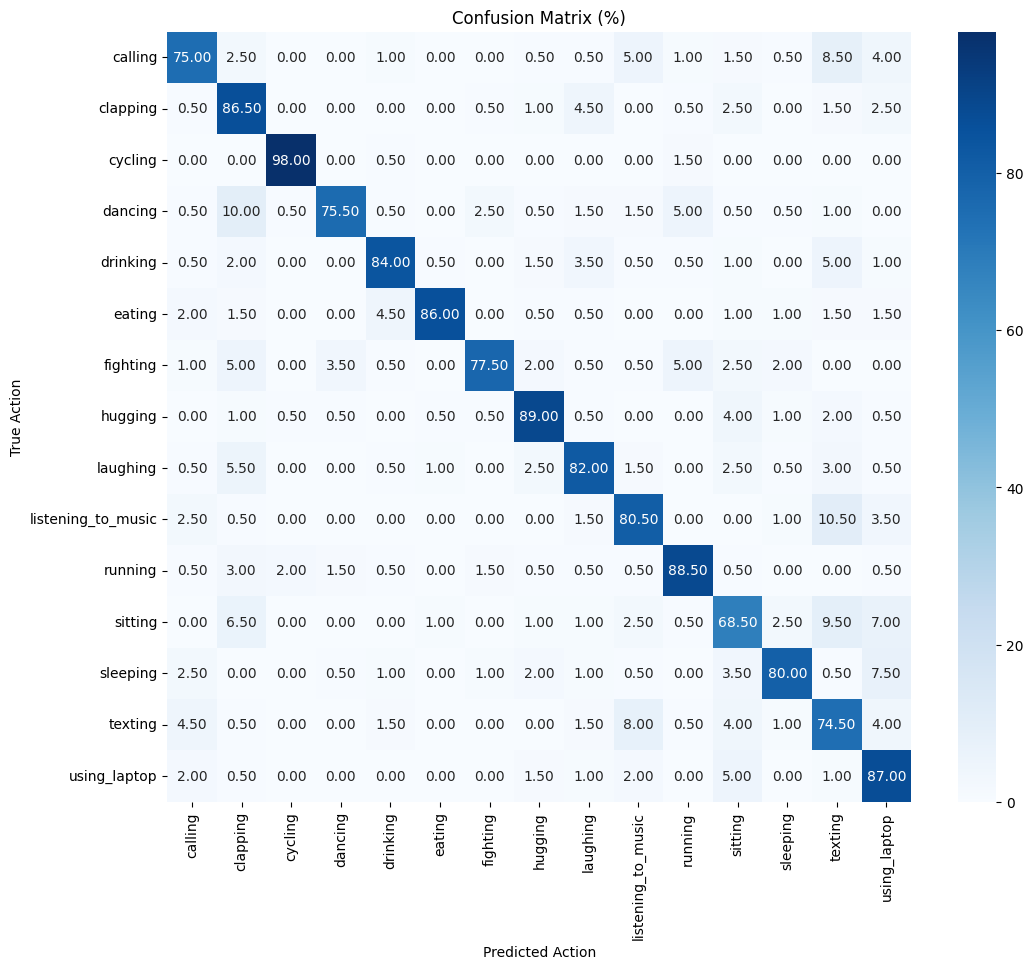


3. Classification Report:
                    precision    recall  f1-score   support

           calling       0.82      0.75      0.78       200
          clapping       0.69      0.86      0.77       200
           cycling       0.97      0.98      0.98       200
           dancing       0.93      0.76      0.83       200
          drinking       0.89      0.84      0.86       200
            eating       0.97      0.86      0.91       200
          fighting       0.93      0.78      0.84       200
           hugging       0.87      0.89      0.88       200
          laughing       0.82      0.82      0.82       200
listening_to_music       0.78      0.81      0.79       200
           running       0.86      0.89      0.87       200
           sitting       0.71      0.69      0.70       200
          sleeping       0.89      0.80      0.84       200
           texting       0.63      0.74      0.68       200
      using_laptop       0.73      0.87      0.79       200

          a

In [ ]:
# 1. Kết nối Google Drive để truy cập dữ liệu và lưu mô hình
from google.colab import drive
drive.mount('/content/drive')  # Gắn kết Google Drive vào Colab, giúp bạn dễ dàng truy cập và lưu trữ tệp từ Google Drive

# 2. Nhập các thư viện cần thiết
import os  # Thư viện thao tác với các tệp và thư mục
import torch  # Thư viện PyTorch để xử lý mô hình học sâu
import torch.nn as nn  # Mạng nơ-ron của PyTorch
from torchvision import transforms  # Thư viện xử lý ảnh của PyTorch
from torch.utils.data import Dataset, DataLoader  # Để xử lý tập dữ liệu và chia thành các batch
from PIL import Image  # Thư viện để xử lý ảnh
import numpy as np  # Thư viện xử lý mảng và ma trận
from tqdm import tqdm  # Thư viện hiển thị thanh tiến độ cho vòng lặp
from sklearn.metrics import confusion_matrix, classification_report  # Để tính toán các chỉ số đánh giá mô hình như ma trận nhầm lẫn và báo cáo phân loại
import seaborn as sns  # Thư viện vẽ biểu đồ, đặc biệt là heatmap
import matplotlib.pyplot as plt  # Thư viện vẽ biểu đồ
from transformers import ViTForImageClassification, ViTConfig  # Thư viện để làm việc với mô hình Vision Transformer (ViT)

# 3. Cấu hình và thiết bị (GPU hoặc CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Kiểm tra xem có GPU không. Nếu có, dùng GPU, nếu không dùng CPU.

# 4. Danh sách các lớp hành động (phải giống như khi huấn luyện mô hình)
ACTION_CLASSES = [
    'calling', 'clapping', 'cycling', 'dancing', 'drinking',
    'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music',
    'running', 'sitting', 'sleeping', 'texting', 'using_laptop'
]

# 5. Transform để xử lý ảnh, phải giống như khi huấn luyện mô hình
test_transform = transforms.Compose([
    transforms.Resize(256),  # Resize ảnh sao cho chiều dài hoặc chiều rộng của ảnh là 256 pixel
    transforms.CenterCrop(224),  # Crop ảnh từ chính giữa với kích thước 224x224 pixel
    transforms.ToTensor(),  # Chuyển ảnh sang tensor (mảng số học)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa ảnh theo giá trị trung bình và độ lệch chuẩn của ImageNet
])

# 6. Định nghĩa Dataset để tải ảnh từ thư mục
class ActionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Constructor để khởi tạo dataset, nhận vào đường dẫn thư mục và các phép biến đổi ảnh.
        root_dir: Thư mục chứa dữ liệu.
        transform: Các phép biến đổi sẽ áp dụng lên ảnh (ví dụ resize, normalize).
        """
        self.root_dir = root_dir  # Đường dẫn đến thư mục chứa các lớp hành động
        self.transform = transform  # Biến đổi ảnh (nếu có)
        self.data = []  # Danh sách chứa ảnh và nhãn

        # Duyệt qua từng lớp hành động và thêm các ảnh vào dataset
        for label, action in enumerate(ACTION_CLASSES):
            action_dir = os.path.join(root_dir, action)  # Đường dẫn đến thư mục của lớp hành động
            if os.path.exists(action_dir):  # Kiểm tra xem thư mục hành động có tồn tại không
                for img_name in os.listdir(action_dir):  # Duyệt qua từng ảnh trong thư mục
                    img_path = os.path.join(action_dir, img_name)  # Đường dẫn đầy đủ đến ảnh
                    self.data.append((img_path, label))  # Lưu đường dẫn ảnh và nhãn vào dataset
            else:
                print(f"Warning: Directory {action_dir} does not exist and will be skipped.")  # Cảnh báo nếu thư mục không tồn tại

    def __len__(self):
        """Trả về số lượng ảnh trong dataset"""
        return len(self.data)

    def __getitem__(self, idx):
        """Lấy ảnh và nhãn của lớp từ dataset theo chỉ số idx"""
        img_path, label = self.data[idx]  # Lấy đường dẫn ảnh và nhãn lớp
        image = Image.open(img_path).convert('RGB')  # Đọc ảnh và chuyển sang định dạng RGB (màu sắc)

        if self.transform:  # Nếu có biến đổi ảnh, áp dụng biến đổi đó
            image = self.transform(image)

        return image, label, img_path  # Trả về ảnh, nhãn và đường dẫn ảnh

# 7. Tải mô hình ViT đã huấn luyện từ tệp
def load_vit_model(model_path):
    """
    Tải mô hình Vision Transformer (ViT) đã huấn luyện từ tệp checkpoint.
    model_path: Đường dẫn tới tệp mô hình đã huấn luyện
    """
    # Khởi tạo cấu hình cho mô hình ViT
    config = ViTConfig.from_pretrained('google/vit-base-patch16-224')  # Sử dụng cấu hình của mô hình ViT cơ bản
    config.num_labels = len(ACTION_CLASSES)  # Số lượng lớp hành động trong bài toán của chúng ta
    model = ViTForImageClassification(config)  # Tạo mô hình ViT với cấu hình đã định

    checkpoint = torch.load(model_path, map_location=device)  # Tải trọng số mô hình từ tệp checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])  # Cập nhật trọng số vào mô hình
    return model.to(device)  # Chuyển mô hình sang GPU hoặc CPU tùy vào thiết bị

# 8. Tải mô hình và thiết lập chế độ đánh giá (eval)
model_path = '/content/drive/MyDrive/Colab Notebooks/Final/best_vit_model.pth'  # Đường dẫn đến mô hình đã huấn luyện
model = load_vit_model(model_path)  # Tải mô hình ViT
model.eval()  # Đặt mô hình vào chế độ đánh giá (eval) để tắt dropout, batch norm,...

# 9. Hàm đánh giá mô hình trên dữ liệu kiểm tra
def evaluate_model(model, test_dir):
    """
    Hàm này sẽ đánh giá mô hình trên tập dữ liệu kiểm tra.
    model: Mô hình đã huấn luyện
    test_dir: Đường dẫn đến thư mục chứa dữ liệu kiểm tra
    """
    # Chuẩn bị dữ liệu kiểm tra
    test_dataset = ActionDataset(test_dir, transform=test_transform)  # Tạo dataset cho tập kiểm tra
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Tạo DataLoader để tải batch ảnh

    # Các biến để lưu kết quả
    correct = 0  # Số lượng dự đoán đúng
    total = 0  # Tổng số ảnh trong tập kiểm tra
    y_true = []  # Danh sách lưu nhãn thật
    y_pred = []  # Danh sách lưu nhãn dự đoán
    img_paths = []  # Danh sách lưu đường dẫn ảnh
    confidence_scores = []  # Danh sách lưu các xác suất dự đoán

    # Lưu các thống kê per-class
    action_correct = {action: 0 for action in ACTION_CLASSES}  # Số lượng dự đoán đúng cho mỗi lớp
    action_total = {action: 0 for action in ACTION_CLASSES}  # Tổng số mẫu của mỗi lớp
    confidence_sums = np.zeros((len(ACTION_CLASSES), len(ACTION_CLASSES)))  # Tổng xác suất cho mỗi lớp

    # Dự đoán trên tập kiểm tra
    with torch.no_grad():  # Tắt tính toán gradient để tiết kiệm bộ nhớ
        for images, labels, paths in tqdm(test_loader):  # Duyệt qua từng batch ảnh trong test_loader
            images, labels = images.to(device), labels.to(device)  # Chuyển ảnh và nhãn lên GPU hoặc CPU
            outputs = model(images)  # Dự đoán đầu ra từ mô hình
            probabilities = torch.softmax(outputs.logits, dim=1)  # Áp dụng softmax để lấy xác suất cho mỗi lớp
            _, predicted = torch.max(outputs.logits, 1)  # Lấy lớp có xác suất cao nhất

            # Cập nhật các chỉ số đánh giá
            total += labels.size(0)  # Tổng số mẫu đã xử lý
            correct += (predicted == labels).sum().item()  # Số lượng dự đoán đúng

            y_true.extend(labels.cpu().numpy())  # Lưu nhãn thật
            y_pred.extend(predicted.cpu().numpy())  # Lưu nhãn dự đoán
            img_paths.extend(paths)  # Lưu đường dẫn ảnh
            confidence_scores.extend(probabilities.cpu().numpy())  # Lưu xác suất dự đoán

            # Phân tích độ tin cậy cho từng lớp
            for prob, label in zip(probabilities, labels):
                confidence_sums[label.item()] += prob.cpu().numpy()

            # Cập nhật độ chính xác cho mỗi lớp
            for label, pred in zip(labels, predicted):
                action_total[ACTION_CLASSES[label.item()]] += 1  # Tăng số mẫu cho lớp
                if label == pred:
                    action_correct[ACTION_CLASSES[label.item()]] += 1  # Tăng số mẫu đúng cho lớp

    # Tính độ chính xác tổng thể
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"\n1. Overall Test Accuracy: {accuracy:.2f}%")

    # Tính độ chính xác cho từng lớp
    print("\nPer-action Accuracy:")
    for action in ACTION_CLASSES:
        if action_total[action] > 0:
            acc = (action_correct[action] / action_total[action]) * 100  # Tính độ chính xác cho lớp
            print(f"{action}: {acc:.2f}%")
        else:
            print(f"{action}: No samples")  # Nếu không có mẫu nào cho lớp đó

    # Phân tích độ tin cậy (Similarity Matrix)
    action_total_values = np.array([action_total.get(action, 1) for action in ACTION_CLASSES])
    confidence_avg = confidence_sums / action_total_values.reshape(-1, 1)  # Tính độ tin cậy trung bình
    similarity_matrix = np.nan_to_num(confidence_avg * 100)  # Tính ma trận tương đồng và chuyển đổi NaN thành 0

    print("\n2. Similarity Matrix (%):")
    print("Rows: True Action, Columns: Predicted Action Confidence")
    for i, true_action in enumerate(ACTION_CLASSES):
        if action_total[true_action] > 0:
            print(f"\nTrue {true_action}:")
            for j, pred_action in enumerate(ACTION_CLASSES):
                print(f"  {pred_action}: {similarity_matrix[i][j]:.2f}%")

    # Vẽ ma trận nhầm lẫn (Confusion Matrix)
    cm = confusion_matrix(y_true, y_pred, labels=range(len(ACTION_CLASSES)))
    cm_percent = (cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)) * 100  # Chuyển sang tỷ lệ phần trăm
    cm_percent = np.nan_to_num(cm_percent)  # Chuyển đổi NaN thành 0

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=ACTION_CLASSES, yticklabels=ACTION_CLASSES)
    plt.xlabel("Predicted Action")
    plt.ylabel("True Action")
    plt.title("Confusion Matrix (%)")
    plt.show()

    # In báo cáo phân loại
    print("\n3. Classification Report:")
    print(classification_report(y_true, y_pred, target_names=ACTION_CLASSES))

    # Phân tích các trường hợp sai (misclassification analysis)
    print("\nConfusion Analysis (Significant Misclassifications, >5%):")
    for i, true_action in enumerate(ACTION_CLASSES):
        if action_total[true_action] == 0:
            continue
        for j, pred_action in enumerate(ACTION_CLASSES):
            if i != j and cm_percent[i][j] > 5:  # Nếu tỷ lệ nhầm lẫn > 5%
                print(f"True '{true_action}' predicted as '{pred_action}': {cm_percent[i][j]:.2f}%")

    # Hiển thị ảnh bị phân loại sai
    print("\nSample Misclassified Images:")
    misclassified_samples = []
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if true != pred and len(misclassified_samples) < 5:  # Hiển thị 5 ảnh bị phân loại sai
            misclassified_samples.append((img_paths[i], ACTION_CLASSES[true], ACTION_CLASSES[pred]))

    for sample in misclassified_samples:
        print(f"Image: {sample[0]} | True: {sample[1]} | Predicted: {sample[2]}")


# 5. CHẠY ĐÁNH GIÁ
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/Final/Data/test_data'
evaluate_model(model, test_data_dir)